In [ ]:
import numpy as np
from google.colab import drive
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import BatchNormalization
import tensorflow as tf
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
import warnings
drive.mount('/content/drive')
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [ ]:
def process_time_column(path):
    df = pd.read_csv(path).drop_duplicates()
    df['utc_time'] = pd.to_datetime(df['utc_time'])
    df['day'], df['time'] = df['utc_time'].dt.date, df['utc_time'].dt.time
    return df.sort_values(by=['id', 'day', 'time']).drop(columns=['Name', 'day', 'time'])

def attach_sequence(df):
    name = df['id'].unique()
    Xbar, ybar = [], []
    for s_name in name:
        sub_df = df[df['id'] == s_name].drop(columns=['id'])
        for idx in range(2, len(sub_df)):
            if sub_df.iloc[idx, 3] + pd.Timedelta(-1, 'h') == sub_df.iloc[idx - 1, 3] and sub_df.iloc[idx, 3] + pd.Timedelta(-2, 'h') == sub_df.iloc[idx - 2, 3]:
                Xbar.append(np.array([np.array(list([np.array(sub_df.iloc[idx - 2, [x for x in range(0, 13) if x not in [2, 3]]], dtype=np.float32), \
                                           np.array(sub_df.iloc[idx - 1, [x for x in range(0, 13) if x not in [2, 3]]], dtype=np.float32), \
                                           np.array(sub_df.iloc[idx, [x for x in range(0, 13) if x not in [2, 3]]], dtype=np.float32)]))]))
                ybar.append(sub_df.iloc[idx, 2])
    Xbar = np.array(Xbar)
    return Xbar.reshape(Xbar.shape[0], Xbar.shape[2], Xbar.shape[3]), np.array(ybar)

def get_train_test_data(num_case):
    path_train = '/content/drive/My Drive/Data_match (new)/cv' +  str(num_case) + '_data_train_92022.csv'
    path_test = '/content/drive/My Drive/Data_match (new)/cv' +  str(num_case) + '_data_test_92022.csv'
    test_X, test_y = attach_sequence(process_time_column(path_test))
    train_X, train_y = attach_sequence(process_time_column(path_train))
    return train_X, train_y, test_X, test_y

def model_b():
    model = Sequential()
    model.add(LSTM(32, input_shape=(3, 11)))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation= tf.keras.activations.sigmoid))
    model.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.AUC()])
    print(model.summary()), model.output_shape
    return model

def model_r():
    model = Sequential()
    model.add(LSTM(32, input_shape=(3, 11)))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError())
    print(model.summary()), model.output_shape
    return model

early_stopping_monitor = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

def get_result(num_case, batch_size, epoch):
    train_X, train_y, test_X, test_y = get_train_test_data(num_case)
    model_cls = model_b()
    model_regr = model_r()
    # training classifier model
    model_cls.fit(train_X, (train_y > 0).astype(np.int16), validation_data=(test_X, (test_y > 0).astype(np.int16)), batch_size=batch_size, epochs=epoch, callbacks=[early_stopping_monitor])
    y_cls_pred = model_cls.predict(test_X)
    # y true is test_y > 0.5
    y_cls_true = (test_y > 0).astype(np.int16)
    a = (model_cls.predict(train_X) > 0.5).astype(np.int16)
    b = (y_cls_pred > 0.5).astype(np.int16)
    # training regressor model
    train_r_y = np.array([train_y[i] for i in range(train_y.shape[0]) if a[i] == 1])
    train_r_X = np.array([train_X[i] for i in range(train_y.shape[0]) if  a[i] == 1])
    b = (model_cls.predict(test_X) > 0.5).astype(np.int16)
    test_r_X, test_r_y = np.array([test_X[i] for i in range(test_X.shape[0]) if b[i] == 1]), np.array([test_y[i] for i in range(test_y.shape[0]) if b[i] == 1])
    model_regr.fit(train_r_X, train_r_y, validation_data=(test_r_X, test_r_y), batch_size=512, epochs=10, callbacks=[early_stopping_monitor])
    y_regr_pred = model_regr.predict(test_X)
    y_regr_pred = np.array([b[i] * y_regr_pred[i] for i in range(y_regr_pred.shape[0])])
    # y_cls_pred return for probability form
    # y_cls_true return for [0, 1] form
    # y_regr_pred return for float form
    # test_y present for y_regr_true
    return y_cls_pred, y_cls_true, y_regr_pred, test_y

---

In [ ]:
y_cls_pred, y_cls_true, y_regr_pred, y_regr_true = get_result(13, 512, 10)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                5632      
                                                                 
 batch_normalization_2 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 8)                 136       
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 6,433
Trainable params: 6,369
Non-trainable params: 64
___________________________________________________

In [ ]:
print(classification_report((y_cls_pred > 0.5).astype(np.int16), y_cls_true))

              precision    recall  f1-score   support

           0       0.49      0.56      0.52      8169
           1       0.70      0.64      0.67     13434

    accuracy                           0.61     21603
   macro avg       0.60      0.60      0.60     21603
weighted avg       0.62      0.61      0.61     21603



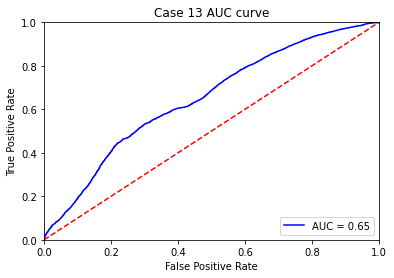

In [ ]:
fpr, tpr, threshold = roc_curve((y_cls_true > 0).astype(np.int16), y_cls_pred)
roc_auc = auc(fpr, tpr)
plt.title('Case 13 AUC curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Text(0.5, 1.0, 'Case 13 CM')

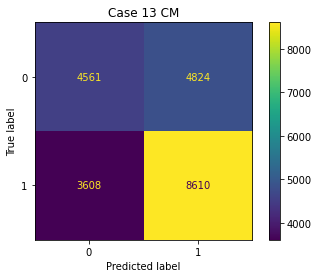

In [ ]:
cfmd = ConfusionMatrixDisplay(confusion_matrix(y_cls_true, (y_cls_pred > 0.5).astype(np.int16)))
cfmd.plot()
cfmd.ax_.set_title("Case 13 CM")

In [ ]:
print('Case 13 MSE: %.2f' % mean_squared_error(y_regr_true, y_regr_pred))

Case 13 MSE: 6.06


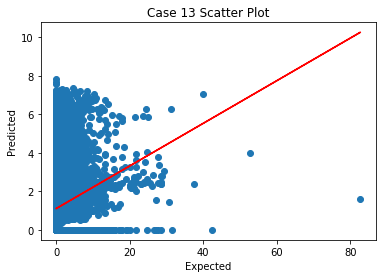

In [ ]:
plt.ylabel('Predicted')
plt.xlabel('Expected')
plt.title('Case 13 Scatter Plot')
plt.plot(y_regr_true, y_regr_pred, 'o')
m, b = np.polyfit(y_regr_true, y_regr_pred, 1)
plt.plot(y_regr_true, m*y_regr_true + b, 'r')
plt.show()

---